This notebook is part of the supplementary material of the books "Online Machine Learning - Eine praxisorientiere Einführung",  
https://link.springer.com/book/9783658425043 and "Online Machine Learning - A Practical Guide with Examples in Python" https://link.springer.com/book/9789819970063
The contents are open source and published under the "BSD 3-Clause License".
This software is provided "as is" without warranty of any kind, either express or implied, including but not limited to implied warranties of merchantability and fitness for a particular purpose. The author or authors assume no liability for any damages or liability, whether in contract, tort, or otherwise, arising out of or in connection with the software or the use or other dealings with the software.

In [1]:
#| echo: false
import os
import numpy as np
import pandas as pd
from math import inf
from sklearn.metrics import mean_absolute_error
from spotRiver.utils.data_conversion import convert_to_df
from river.datasets import synth
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

* This notebook exemplifies hyperparameter tuning with SPOT (spotPython and spotRiver).
* This notebook demonstrates hyperparameter tuning for `river`. It is based on the notebook "Incremental decision trees in river: the Hoeffding Tree case", see: [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters).
* Here we will use the river `HTR` and `HATR` functions as in "Incremental decision trees in river: the Hoeffding Tree case", see: [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/#42-regression-tree-splitters).

## The Friedman Drift Data Set {#sec-the-friedman-drift-data-set-24}

We will use the Friedman synthetic dataset with concept drifts, which is described in detail in @sec-a-05-friedman.
The following parameters are used to generate and handle the data set:

* `position`: The positions of the concept drifts.
* `n_train`: The number of samples used for training.
* `n_val`: The number of samples used for validation. This data set is used during the hyperparameter tuning as a validation set.
* `n_test`: The number of samples used for testing. This data set is not used during the hyperparameter tuning.
* `seed`: The seed for the random number generator.
* `target_column`: The name of the target column.
* `drift_type`: The type of the concept drift.

We will use `spotRiver`'s `convert_to_df` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/utils/data_conversion.py) to convert the `river` data set to a `pandas` data frame.
Then we add column names x1 until x10 to the first 10 columns of the dataframe and the column name y to the last column of the dataframe.

This data generation is later independently repeated for the training and test data sets to obtain different data sets for training and testing (better validation) during the tuning and the final evaluation after the tuning is finished.

We generate a small training data set with 7*42 samples and a large validation data set. 

In [2]:
from sklearn.metrics import mean_absolute_error
from river.datasets import synth
from spotRiver.utils.data_conversion import convert_to_df

target_column = "y"
metric = mean_absolute_error
horizon = 7*24
n_train = horizon
p_1 = int(n_train/4)
p_2 = int(n_train/2)
position=(p_1, p_2)
dataset_train = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=123
)

train = convert_to_df(dataset_train, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

In [3]:
n_val = 100_000
p_1 = int(n_val/4)
p_2 = int(n_val/2)
position=(p_1, p_2)
dataset_val = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=124
)
val = convert_to_df(dataset_val, n_total=n_val)
val.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

Data sets that are available as `pandas` dataframes can easily be passed to the `spot` hyperparameter tuner.
`spotpython` requires a `train` and a `test` data set, where the column names must be identical.

In [4]:
# combine the train and val data (train data first, val data second) in order to have a single dataset and save it to a csv file. Include the number of train and val samples in the file name.
data = pd.concat([train, val])
data.to_csv(f"./data/synth_friedman_drift_train{n_train}_val{n_val}.csv", index=False)

## Setup

### General Experiment Setup

To keep track of the different experiments, we use a `PREFIX` for the experiment name. The `PREFIX` is used to create a unique experiment name. The `PREFIX` is also used to create a unique TensorBoard folder, which is used to store the TensorBoard log files.

`spotpython` allows the specification of two different types of stopping criteria: first, the number of function evaluations (`fun_evals`), and second, the maximum run time in seconds (`max_time`). Here, we will set the number of function evaluations to infinity and the maximum run time to one minute.

Furthermore, we set the initial design size (`init_size`) to 10. The initial design is used to train the surrogate model. The surrogate model is used to predict the performance of the hyperparameter configurations. The initial design is also used to train the first model. Since the `init_size` belongs to the experimental design, it is set in the `design_control` dictionary, see [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/utils/init/#spotPython.utils.init.design_control_init).

`max_time` is set to one minute for demonstration purposes and `init_size` is set to 10 for demonstration purposes. For real experiments, these values should be increased.
Note,  the total run time may exceed the specified `max_time`, because the initial design is always evaluated, even if this takes longer than `max_time`.



The following parameters are used to specify the general experiment setup:

In [5]:
PREFIX = "CH10"
fun_evals = inf
max_time = 60
init_size = 10

### Data Setup

We use the `StandardScaler` [[SOURCE]](https://riverml.xyz/dev/api/preprocessing/StandardScaler/) from `river` as the data-preprocessing model. The `StandardScaler` is used to standardize the data set, i.e., it has zero mean and unit variance.

The names of the training and test data sets are `train` and `test`, respectively. They are available as `pandas` dataframes.
Both must use the same column names. The column names were set to `x1` to `x10` for the features and `y` for the target column during the data set generation in @sec-the-friedman-drift-data-set-24. Therefore, the `target_column` is set to `y` (as above).


The following parameters are used to specify the data setup:

In [6]:
prep_model_name = "StandardScaler"
test = val # here we used the validation set as test set
train = train
target_column = "y"

### Evaluation Setup

Here we use the `mean_absolute_error` [[SOURCE]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as the evaluation metric.
Internally, this metric is passed to the objective (or loss) function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py) and further to the evaluation function `eval_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_bml.py).

`spotRiver` also supports additional metrics. For example, the `metric_river` is used for the river based evaluation via `eval_oml_iter_progressive` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/evaluation/eval_oml.py). The `metric_river` is implemented to simulate the behaviour of the "original" `river` metrics.



The following parameter are used to select the evaluation metric:

In [7]:
metric_sklearn_name = "mean_absolute_error"

### River-Specific Setup 

In the online-machine-learning (OML) setup, the model is trained on a fixed number of observations and then evaluated on a fixed number of observations. The `horizon` defines the number of observations that are used for the evaluation. Here, a horizon of 7*24 is used, which corresponds to one week of data.

The `oml_grace_period` defines the number of observations that are used for the initial training of the model.
This value is relatively small, since the online-machine-learning is trained on the incoming data and the model is updated continuously.
However, it needs a certain number of observations to start the training process.
Therefore, this short training period aka `oml_grace_period` is set to the horizon, i.e., the number of observations that are used for the evaluation.
In this case, we use a horizon of 7*24.

The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased. `spotRiver` stores information about the model' s score (metric), memory, and time. The hyperparamter tuner requires a single objective.
Therefore, a weighted sum of the metric, memory, and time is computed. The weights are defined in the `weights` array.
The `weights` provide a flexible way to define specific requirements, e.g., if the memory is more important than the time, the weight for the memory can be increased.

The `weight_coeff` defines a multiplier for the results: results are multiplied by (step/n_steps)**weight_coeff, where n_steps is the total number of iterations.
Results from the beginning have a lower weight than results from the end if weight_coeff > 1. If weight_coeff == 0, all results have equal weight. Note, that the `weight_coeff` is only used internally for the tuner and does not affect the results that are used for the evaluation or comparisons.

The following parameters are used for the River setup:

In [8]:
horizon = 7*24
oml_grace_period = 7*24
weights = np.array([1, 0.01, 0.01])
weight_coeff = 0.0

### Model Setup

By using `core_model_name = "tree.HoeffdingTreeRegressor"`, the `river` model class `HoeffdingTreeRegressor` [[SOURCE]](https://riverml.xyz/dev/api/tree/HoeffdingTreeRegressor/) from the `tree` module is selected.
For a given `core_model_name`, the corresponding hyperparameters are automatically loaded from the associated dictionary, which is stored as a JSON file. The JSON file contains hyperparameter type information, names, and bounds. For `river` models, the hyperparameters are stored in the `RiverHyperDict`, see [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json)

Alternatively, you can load a local hyper_dict. Simply set `river_hyper_dict.json` as the filename. If `filename`is set to `None`, which is the default, the hyper_dict [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/data/river_hyper_dict.json) is loaded from the `spotRiver` package.

How hyperparameter levels can be modified is described in @sec-modifying-hyperparameter-levels.


The following parameters are used for the model setup:

In [9]:
from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.hyperdict.river_hyper_dict import RiverHyperDict
core_model_name = "tree.HoeffdingTreeRegressor"
hyperdict = RiverHyperDict


### Objective Function Setup

The loss function (metric) values are passed to the objective function `fun_oml_horizon` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotRiver/blob/main/src/spotRiver/fun/hyperriver.py), which combines information about the loss, required memory and time as described in @sec-river-specific-setup-24.


The following parameters are used for the objective function setup:

In [10]:
fun = HyperRiver().fun_oml_horizon

### Surrogate Model Setup

The default surrogate model is the `Kriging` model, see [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/build/kriging/). We specify `noise` as `True` to include noise in the model. An `anisotropic` kernel is used, which allows different length scales for each dimension, by setting `n_theta = 2`. Furthermore, the interval for the `Lambda` value is set to `[1e-3, 1e2]`.

These parameters are set in the `surrogate_control` dictionary and therefore passed  to the `surrogate_control_init` function [[SOURCE]](https://sequential-parameter-optimization.github.io/spotPython/reference/spotPython/utils/init/#spotPython.utils.init.surrogate_control_init).

In [11]:
noise = True
n_theta = 2
min_Lambda = 1e-3
max_Lambda = 10

### Summary: Setting up the Experiment

At this stage, all required information is available to set up the dictionaries for the hyperparameter tuning.
Altogether, the `fun_control`, `design_control`, `surrogate_control`, and `optimize_control` dictionaries are initialized as follows:

In [12]:
from math import inf
import numpy as np
from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.hyperdict.river_hyper_dict import RiverHyperDict
from spotPython.utils.init import fun_control_init, design_control_init, surrogate_control_init, optimizer_control_init

fun = HyperRiver().fun_oml_horizon

fun_control = fun_control_init(
    PREFIX="CH10",
    fun_evals=inf,
    max_time=60,

    prep_model_name="StandardScaler",
    test=val, # tuner uses the validation set as test set
    train=train,
    target_column=target_column,

    metric_sklearn_name="mean_absolute_error",
    horizon=7*24,
    oml_grace_period=7*24,
    weight_coeff=0.0,
    weights=np.array([1, 0.01, 0.01]),

    core_model_name="tree.HoeffdingTreeRegressor",
    hyperdict=RiverHyperDict,
   )


design_control = design_control_init(
    init_size=10,
)

surrogate_control = surrogate_control_init(
    noise=True,
    n_theta=2,
    min_Lambda=1e-3,
    max_Lambda=10,
)

optimizer_control = optimizer_control_init()

Seed set to 123


Created spot_tensorboard_path: runs/spot_logs/CH10_maans14_2024-08-01_17-20-15 for SummaryWriter()


### Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model`

* Numeric and boolean values can be modified using the modify_hyper_parameter_bounds method.
* Factors can be modified with the modify_hyper_parameter_levels function.

In [13]:
from spotPython.hyperparameters.values import modify_hyper_parameter_bounds
modify_hyper_parameter_bounds(fun_control, "delta", [1e-10, 1e-6])
print(fun_control["core_model_hyper_dict"]["delta"])

{'type': 'float', 'default': 1e-07, 'transform': 'None', 'lower': 1e-10, 'upper': 1e-06}


Hyperparameters can be excluded from the tuning procedure by selecting identical values for the lower and upper bounds. For example, the hyperparameter `merit_preprune` is excluded from the tuning procedure by setting the bounds to `[0, 0]`.

In [14]:
modify_hyper_parameter_bounds(fun_control,  "merit_preprune", [0, 0])

### Run the `Spot` Optimizer

The class `Spot` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) is the hyperparameter tuning workhorse. It is initialized with the following parameters, which were specified above.

* `fun`: the objective function
* `fun_control`: the dictionary with the control parameters for the objective function
* `design_control`: the dictionary with the control parameters for the experimental design
* `surrogate_control`: the dictionary with the control parameters for the surrogate model
* `optimizer_control`: the dictionary with the control parameters for the optimizer

`spotpython` allows maximum flexibility in the definition of the hyperparameter tuning setup. Alternative surrogate models, optimizers, and experimental designs can be used. Thus, interfaces for the `surrogate` model, experimental `design`, and `optimizer` are provided. The default surrogate model is the kriging model, the default optimizer is the differential evolution, and default experimental design is the Latin hypercube design.


The following parameters are used for the `Spot` setup. These were specified above:

In [15]:
fun = fun
fun_control = fun_control
design_control = design_control
surrogate_control = surrogate_control
optimizer_control = optimizer_control

In [16]:
from spotPython.spot import spot
spot_tuner = spot.Spot(
    fun=fun,
    fun_control=fun_control,
    design_control=design_control,
    surrogate_control=surrogate_control,
    optimizer_control=optimizer_control,
)
res = spot_tuner.run()

Seed set to 123


spotPython tuning: 1.7158334462114646 [----------] 1.32% 
spotPython tuning: 1.7158334462114646 [----------] 3.33% 
spotPython tuning: 1.7158334462114646 [----------] 4.91% 
spotPython tuning: 1.7158334462114646 [#---------] 5.53% 
spotPython tuning: 1.7158334462114646 [#---------] 8.27% 
spotPython tuning: 1.7158334462114646 [#---------] 10.92% 
spotPython tuning: 1.7155031588787444 [#---------] 12.63% 
spotPython tuning: 1.7155031588787444 [#---------] 14.41% 
spotPython tuning: 1.7141693482429414 [##--------] 16.31% 
spotPython tuning: 1.688522605534473 [##--------] 18.22% 
spotPython tuning: 1.6884637290148463 [##--------] 19.99% 
spotPython tuning: 1.6884637290148463 [##--------] 21.82% 
spotPython tuning: 1.6882750914786335 [##--------] 23.62% 
spotPython tuning: 1.6882750914786335 [###-------] 25.50% 
spotPython tuning: 1.6882750914786335 [###-------] 27.39% 
spotPython tuning: 1.6882750914786335 [###-------] 29.37% 
spotPython tuning: 1.6882750914786335 [###-------] 31.49% 
spo

::: {.callout-note}
#### Note: Active and Inactive Hyperparameters
Hyperparameters can be excluded from the tuning procedure by selecting identical values for the lower and upper bounds. For example, the hyperparameter `merit_preprune` is excluded from the tuning procedure by setting the bounds to `[0, 0]`.
:::




`spotPython`'s method `gen_design_table` summarizes the experimental design that is used for the hyperparameter tuning:

In [17]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name                   | type   | default          |   lower |    upper | transform              |
|------------------------|--------|------------------|---------|----------|------------------------|
| grace_period           | int    | 200              |  10     | 1000     | None                   |
| max_depth              | int    | 20               |   2     |   20     | transform_power_2_int  |
| delta                  | float  | 1e-07            |   1e-10 |    1e-06 | None                   |
| tau                    | float  | 0.05             |   0.01  |    0.1   | None                   |
| leaf_prediction        | factor | mean             |   0     |    2     | None                   |
| leaf_model             | factor | LinearRegression |   0     |    2     | None                   |
| model_selector_decay   | float  | 0.95             |   0.9   |    0.99  | None                   |
| splitter               | factor | EBSTSplitter     |   0     |    2     | None           

### TensorBoard {#sec-tensorboard-13}

Now we can start TensorBoard in the background with the following command, where `./runs` is the default directory for the TensorBoard log files:

`tensorboard --logdir="./runs" --port=6006 &`

:::{.callout-tip}
#### Tip: TENSORBOARD_PATH
The TensorBoard path can be printed with the following command:

`from spotPython.utils.file import get_tensorboard_path`
`get_tensorboard_path(fun_control)`

:::

We can access the TensorBoard web server with the following URL:

`http://localhost:6006/`

The TensorBoard plot illustrates how `spotPython` can be used as a microscope for the internal mechanisms of the surrogate-based optimization process. Here, one important parameter, the learning rate $\theta$ of the Kriging surrogate [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/build/kriging.py) is plotted against the number of optimization steps.

![TensorBoard visualization of the spotPython optimization process and the surrogate model.](./13_tensorboard_01.png){width="100%"}

### Results

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized with `spotpython`'s method `plot_progress`. The black points represent the performace values (score or metric) of  hyperparameter configurations from the initial design, whereas the red points represents the  hyperparameter configurations found by the surrogate model based optimization.After the hyperparameter tuning run is finished, the results can be saved and reloaded with the following commands:

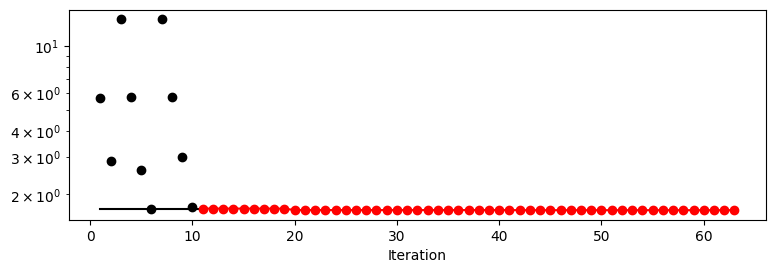

In [18]:
spot_tuner.plot_progress(log_y=True, filename="./figures/" + PREFIX +"_progress.pdf")

Results can also be printed in tabular form.

In [19]:
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name                   | type   | default          |   lower |   upper | tuned              | transform              |   importance | stars   |
|------------------------|--------|------------------|---------|---------|--------------------|------------------------|--------------|---------|
| grace_period           | int    | 200              |    10.0 |  1000.0 | 155.0              | None                   |         0.00 |         |
| max_depth              | int    | 20               |     2.0 |    20.0 | 7.0                | transform_power_2_int  |         0.00 |         |
| delta                  | float  | 1e-07            |   1e-10 |   1e-06 | 1e-10              | None                   |         3.82 | *       |
| tau                    | float  | 0.05             |    0.01 |     0.1 | 0.0757236793202999 | None                   |         0.00 |         |
| leaf_prediction        | factor | mean             |     0.0 |     2.0 | model              | None                   |    

A histogram can be used to visualize the most important hyperparameters.

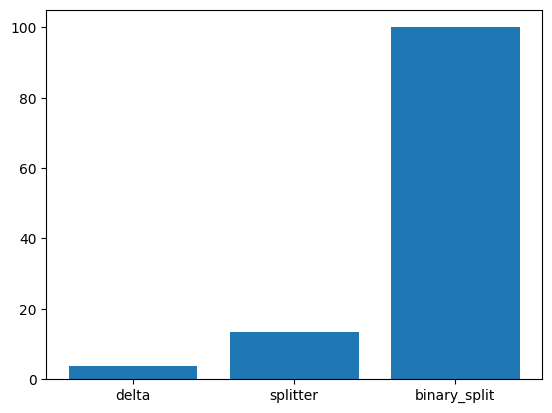

In [20]:
spot_tuner.plot_importance(threshold=1, filename="./figures/" + PREFIX+"_importance.pdf")

## Get Default Hyperparameters

The default hyperparameters, which will be used for a comparison with the tuned hyperparameters, can be obtained with the following commands:

In [21]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
X_start = get_default_hyperparameters_as_array(fun_control)
model_default = get_one_core_model_from_X(X_start, fun_control)
model_default

HoeffdingTreeRegressor (
  grace_period=200
  max_depth=1048576
  delta=1e-07
  tau=0.05
  leaf_prediction="mean"
  leaf_model=LinearRegression (
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    loss=Squared ()
    l2=0.
    l1=0.
    intercept_init=0.
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  model_selector_decay=0.95
  nominal_attributes=None
  splitter=EBSTSplitter ()
  min_samples_split=5
  binary_split=False
  max_size=500.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
)

:::{.callout-note}
#### Note: `spotPython` tunes numpy arrays
* `spotPython` tunes numpy arrays, i.e., the hyperparameters are stored in a numpy array.
::::

The model with the default hyperparameters can be trained and evaluated with the following commands:

* Geneate train and test data as above, but with different seeds.

In [22]:
target_column = "y"
metric = mean_absolute_error
horizon = 7*24
n_train = horizon
p_1 = int(n_train/4)
p_2 = int(n_train/2)
position=(p_1, p_2)
dataset_train = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=125
)

train = convert_to_df(dataset_train, n_total=n_train)
train.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

In [23]:
n_test = 1_000_000
p_1 = int(n_test/4)
p_2 = int(n_test/2)
position=(p_1, p_2)
dataset_test = synth.FriedmanDrift(
   drift_type='gra',
   position=position,
   seed=126
)
test = convert_to_df(dataset_test, n_total=n_test)
test.columns = [f"x{i}" for i in range(1, 11)] + [target_column]

In [24]:
from spotRiver.evaluation.eval_bml import eval_oml_horizon

df_eval_default, df_true_default = eval_oml_horizon(
                    model=model_default,
                    train=train,
                    test=test,
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

The three performance criteria, i.e., score (metric), runtime, and memory consumption, can be visualized with the following commands:

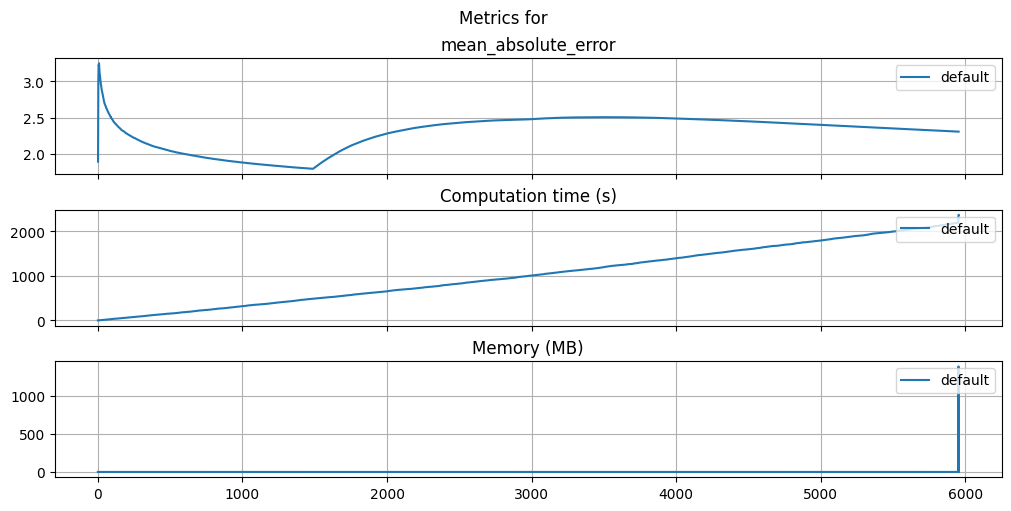

In [25]:
from spotRiver.evaluation.eval_bml import plot_bml_oml_horizon_metrics, plot_bml_oml_horizon_predictions
df_labels=["default"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"])

## Show Predictions

* Select a subset of the data set for the visualization of the predictions:
    * We use the mean, $m$, of the data set as the center of the visualization.
    * We use 100 data points, i.e., $m \pm 50$ as the visualization window.

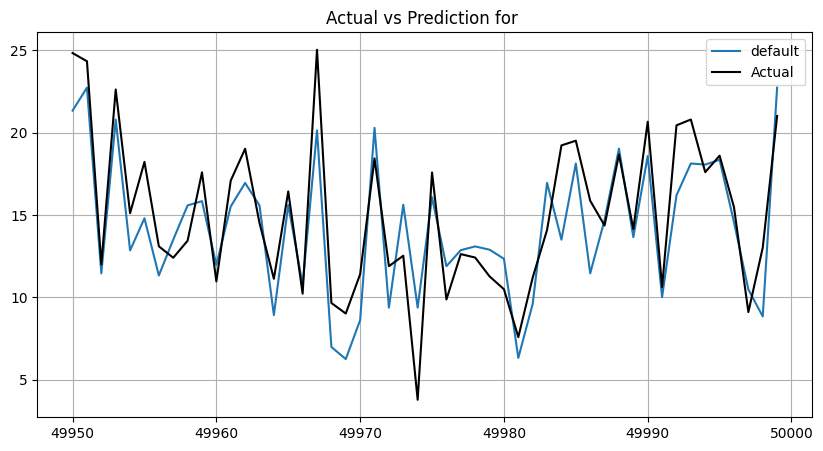

In [26]:
m = fun_control["test"].shape[0]
a = int(m/2)-50
b = int(m/2)
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b]], target_column=target_column,  df_labels=df_labels)

## Get SPOT Results

In a similar way, we can obtain the hyperparameters found by `spotPython`.

In [27]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)

In [28]:
df_eval_spot, df_true_spot = eval_oml_horizon(
                    model=model_spot,
                    train=train,
                    test=test,
                    target_column=fun_control["target_column"],
                    horizon=fun_control["horizon"],
                    oml_grace_period=fun_control["oml_grace_period"],
                    metric=fun_control["metric_sklearn"],
                )

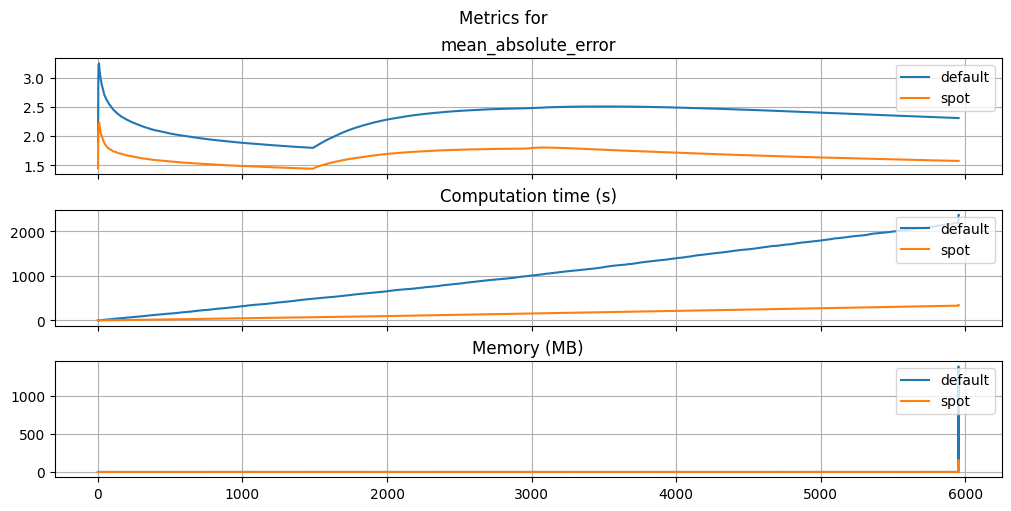

In [29]:
df_labels=["default", "spot"]
plot_bml_oml_horizon_metrics(df_eval = [df_eval_default, df_eval_spot], log_y=False, df_labels=df_labels, metric=fun_control["metric_sklearn"], filename="./figures/" +PREFIX+"_metrics.pdf")

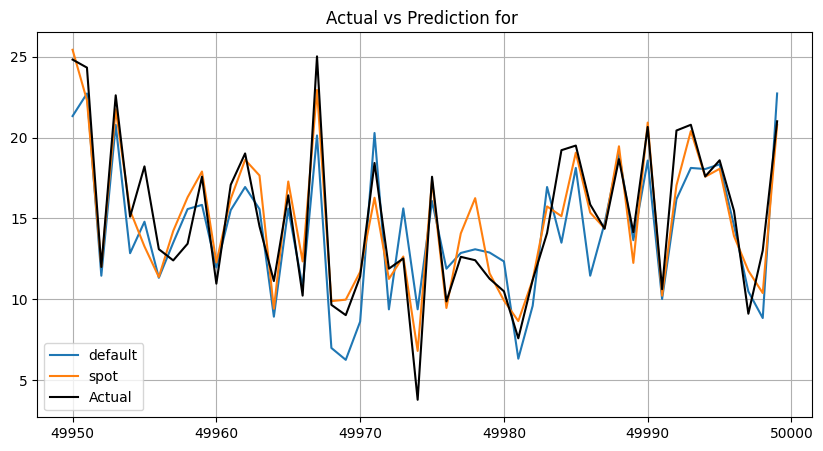

In [30]:
plot_bml_oml_horizon_predictions(df_true = [df_true_default[a:b], df_true_spot[a:b]], target_column=target_column,  df_labels=df_labels, filename="./figures/" + PREFIX +"_predictions.pdf")

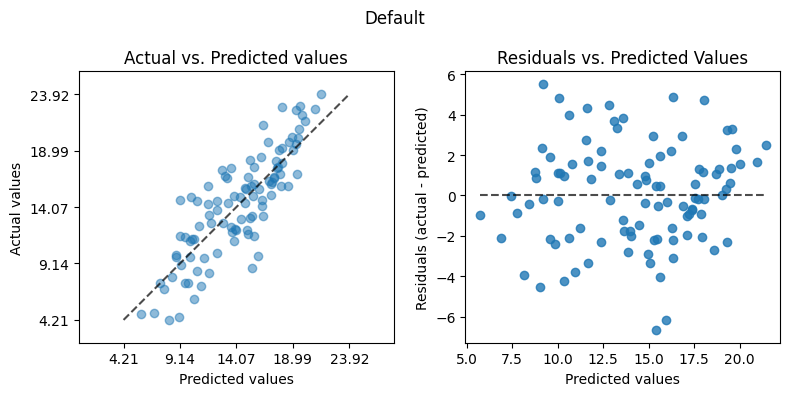

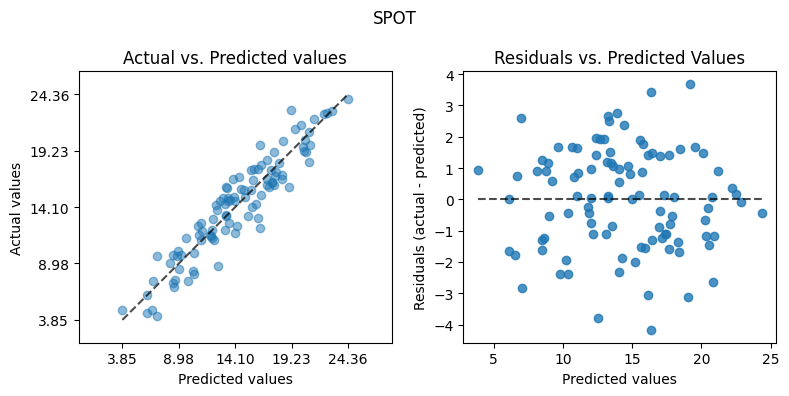

In [31]:
from spotPython.plot.validation import plot_actual_vs_predicted
plot_actual_vs_predicted(y_test=df_true_default[target_column], y_pred=df_true_default["Prediction"], title="Default")
plot_actual_vs_predicted(y_test=df_true_spot[target_column], y_pred=df_true_spot["Prediction"], title="SPOT")

## Visualize Regression Trees

In [32]:
dataset_f = dataset_test.take(n_test)
for x, y in dataset_f:
    model_default.learn_one(x, y)

:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::

In [33]:
# model_default.draw()

In [34]:
model_default.summary

{'n_nodes': 3911,
 'n_branches': 1955,
 'n_leaves': 1956,
 'n_active_leaves': 930,
 'n_inactive_leaves': 1026,
 'height': 23,
 'total_observed_weight': 2000168.0}

### Spot Model

In [35]:
dataset_f = dataset_test.take(n_test)
for x, y in dataset_f:
    model_spot.learn_one(x, y)

:::{.callout-caution}
### Caution: Large Trees
* Since the trees are large, the visualization is suppressed by default.
* To visualize the trees, uncomment the following line.
:::

In [36]:
# model_spot.draw()

In [37]:
model_spot.summary

{'n_nodes': 5491,
 'n_branches': 2745,
 'n_leaves': 2746,
 'n_active_leaves': 2746,
 'n_inactive_leaves': 0,
 'height': 30,
 'total_observed_weight': 2000168.0}

In [38]:
from spotPython.utils.eda import compare_two_tree_models
print(compare_two_tree_models(model_default, model_spot))

| Parameter             |     Default |        Spot |
|-----------------------|-------------|-------------|
| n_nodes               |        3911 |        5491 |
| n_branches            |        1955 |        2745 |
| n_leaves              |        1956 |        2746 |
| n_active_leaves       |         930 |        2746 |
| n_inactive_leaves     |        1026 |           0 |
| height                |          23 |          30 |
| total_observed_weight | 2.00017e+06 | 2.00017e+06 |


## Detailed Hyperparameter Plots

grace_period:  0.0019611137184748118
max_depth:  0.0019611137184748118
delta:  3.8236950486729864
tau:  0.0019611137184748118
leaf_prediction:  0.20130364566279205
leaf_model:  0.0019611137184748118
model_selector_decay:  0.0019611137184748118
splitter:  13.337432009451488
min_samples_split:  0.009113494040875312
binary_split:  100.0
max_size:  0.0019611137184748118
memory_estimate_period:  0.0019611137184748118
stop_mem_management:  0.0019611137184748118
remove_poor_attrs:  0.004628266776637169
impo: [['grace_period', 0.0019611137184748118], ['max_depth', 0.0019611137184748118], ['delta', 3.8236950486729864], ['tau', 0.0019611137184748118], ['leaf_prediction', 0.20130364566279205], ['leaf_model', 0.0019611137184748118], ['model_selector_decay', 0.0019611137184748118], ['splitter', 13.337432009451488], ['min_samples_split', 0.009113494040875312], ['binary_split', 100.0], ['max_size', 0.0019611137184748118], ['memory_estimate_period', 0.0019611137184748118], ['stop_mem_management', 0.00

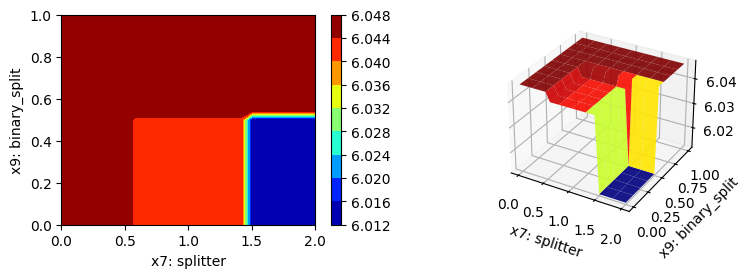

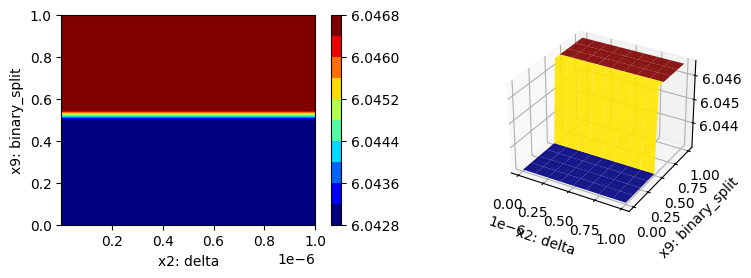

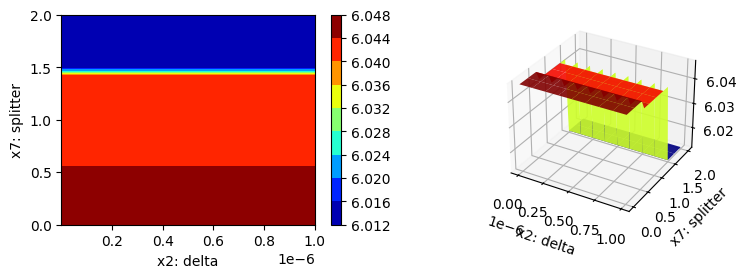

In [39]:
filename = "./figures/" + PREFIX + "_important_hyperparameter_contour.pdf"
spot_tuner.plot_important_hyperparameter_contour(filename=filename, max_imp=3)

## Parallel Coordinates Plots

In [40]:
spot_tuner.parallel_plot()